      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    

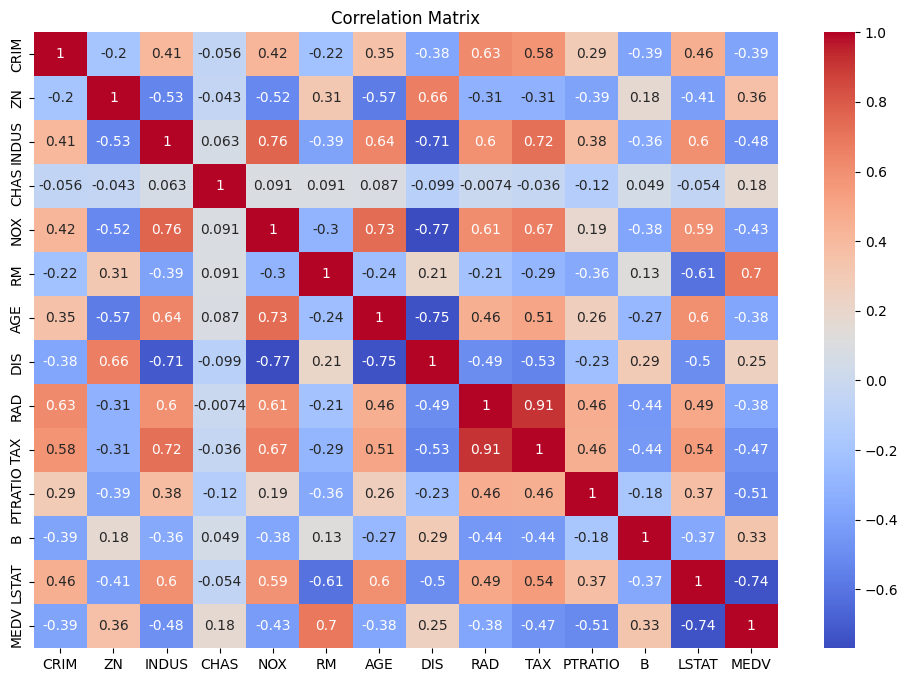

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('boston.csv')

# Display the first few rows
print(data.head())

# Summary statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())

# Visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [2]:
# Handle missing values (if any)
data.fillna(data.mean(), inplace=True)

# Handle outliers using IQR
Q1 = data.quantile(0.25)
# Handle missing values (if any)
data.fillna(data.mean(), inplace=True)

# Handle outliers using IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Normalize/Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop(columns=['MEDV']))
data_scaled = pd.DataFrame(data_scaled, columns=data.columns[:-1])
data_scaled['MEDV'] = data['MEDV']
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop(columns=['MEDV']))
data_scaled = pd.DataFrame(data_scaled, columns=data.columns[:-1])
data_scaled['MEDV'] = data['MEDV']

In [3]:
from sklearn.model_selection import train_test_split

X = data_scaled.drop(columns=['MEDV'])
y = data_scaled['MEDV']

# Split into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
model = RandomForestRegressor(random_state=42)

In [5]:
# Check for missing values in y_train
print("Missing values in y_train:", y_train.isnull().sum())

# Handle missing values in y_train (Option 1: Remove rows)
X_train = X_train[~y_train.isnull()]
y_train = y_train.dropna()

# Recheck for missing values
print("Missing values in y_train after handling:", y_train.isnull().sum())

# Retrain the model
model.fit(X_train, y_train)

Missing values in y_train: 73
Missing values in y_train after handling: 0


RandomForestRegressor(random_state=42)

In [6]:
# Check for missing values in y_val
print("Missing values in y_val:", y_val.isnull().sum())

# Handle missing values in y_val (Option 1: Remove rows)
X_val = X_val[~y_val.isnull()]
y_val = y_val.dropna()

# Recheck for missing values
print("Missing values in y_val after handling:", y_val.isnull().sum())

# Define the model and hyperparameter grid
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    error_score='raise'
)

# Fit the grid search on the validation set
grid_search.fit(X_val, y_val)

# Retrieve the best model and hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Missing values in y_val: 16
Missing values in y_val after handling: 0
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}


In [9]:
# Check for missing values in y_test and y_pred
print("Missing values in y_test:", y_test.isnull().sum())

# Handle missing values in y_test (Option 1: Remove rows)
# Remove rows with missing values from X_test and y_test
X_test = X_test[~y_test.isnull()]  # Select rows where y_test is not null
y_test = y_test.dropna()  # Drop rows with NaN values from y_test


# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

print("Missing values in y_pred:", pd.Series(y_pred).isnull().sum())

# Ensure y_test and y_pred have the same length
if len(y_test) != len(y_pred):
    print("Mismatch in lengths. Aligning y_pred with y_test...")
    y_pred = y_pred[:len(y_test)]  # Truncate y_pred to match y_test

# Recheck lengths
print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))

# Recalculate metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R² Score: {r2}")
print(f"MAE: {mae}")

Missing values in y_test: 6
Missing values in y_pred: 0
Length of y_test: 35
Length of y_pred: 35
MSE: 24.004605096726017
R² Score: -0.009008693086506758
MAE: 3.693502713795187


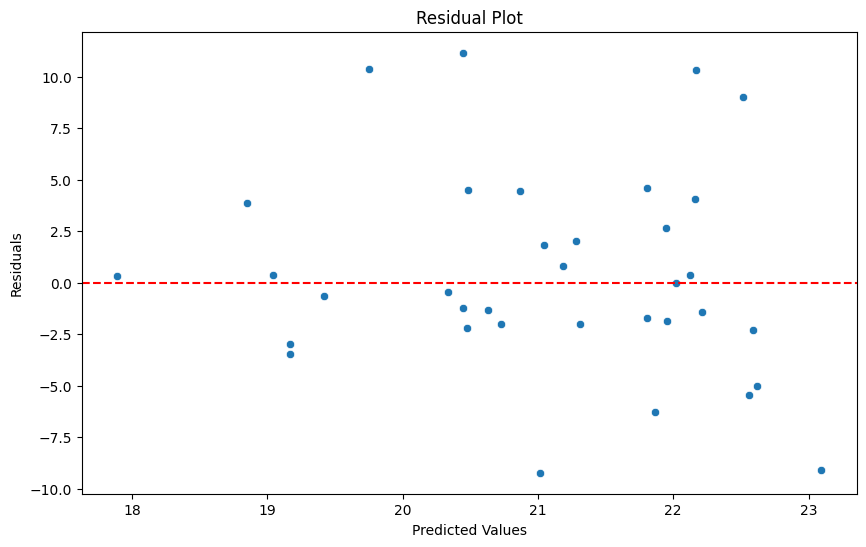

In [10]:
# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [14]:
import pickle

# Save the model using pickle
with open("boston_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [15]:
import pickle

with open("boston_model.pkl", "rb") as f:
    model = pickle.load(f)
    print(type(model))

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
